# Project Proposal: Predicting the Presence of Heart Disease

### Introduction
   
Heart disease refers to the buildup of plaque in the heart's arteries that can ultimately lead to a heart attack, heart failure, or death.  [The Government of Canada website](https://www.canada.ca/en/public-health/services/publications/diseases-conditions/heart-disease-canada.html) identifies heart disease as the 2nd leading cause of death in Canada.  According to 2017–2018 data from the Canadian Chronic Disease Surveillance System (CCDSS):  
* about 1 in 12 (or 2.6 million) Canadian adults age 20 and over live with diagnosed heart disease
* every hour, about 14 Canadian adults age 20 and over with diagnosed heart disease die

Heart disease impacts a significant portion of the population and prevention of heart disease is clearly important so that more people can live longer, healthier lives.  The development of data-driven methods for predicting heart disease can be used to improve prevention processes by advancing our understanding of the associated risk factors and identifying disease at early onset to allow for rapid intervention.

The Cleveland Heart Disease database ([cleve.mod](https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/cleve.mod)), available from the [UCI machine learning repository](https://archive.ics.uci.edu/ml/datasets/Heart+Disease), contains 14 variables related to heart disease diagnosis in 303 anonymous patients.  The variable information is as follows:    

* Age (years) 
* Sex (male or female)
* Chest pain type (typical angina, atypical angina, non-anginal pain, asymptomatic)
* Resting blood pressure (mm Hg)
* Cholesterol (mg/dl)
* Fasting blood sugar < 120 mg/dl (true or false)
* Resting electrocardiographic results (normal, abnormal, hypertrophy)
* Max. heart rate (BPM)
* Exercise induced angina (true or false)
* Oldpeak - ST depression induced by exercise relative to rest (mm)
* Slope - the slope of the peak exercise ST segment (upsloping, flat, down sloping)
* Number of major vessels colored by fluoroscopy (0 to 3)  
* Thalassemia blood disorder (normal, fixed defect, reversible defect)
* Presence of heart disease (yes or no)

This project aims to answer the question: can we use the Cleveland Heart Disease data set to develop a classification model to predict the presence of heart disease in a patient, and if so, what is the accuracy of the classification model?

### Exploratory Analysis
In the exploratory analysis, we read the Cleveland Heart Disease data set from the web into R 
and clean and wrangle the data into a tidy format.  From the initial set of 13 possible predictor variables we can eliminate those that do not contain numerical data, reducing the number of possible predictor variables to 6 (i.e., age, resting blood pressure, cholesterol, max. heart rate, oldpeak, and number of major vessels colored). We split the data into a training and testing sets assuming a 75/25 split and then generate summary tables and visualizations (box plots and bar charts) from the testing set to determine which numerical variables to use to predict the categorical class variable (presence of heart disease).



Source of data set: https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/cleve.mod

In [14]:
# load libraries and set seed value
library(tidyverse)
library(repr)
library(tidymodels)
library(cowplot)
options(repr.matrix.max.rows = 6)
set.seed(2000) 

In [3]:
set.seed(2000) 

# read data set from web
data <- read_table("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/cleve.mod", skip = 19, col_names=FALSE) 

# assign column names
colnames(data) <- c("age", "sex", "chest_pain_type", "resting_blood_pres", "cholesterol", "fasting_blood_sugar < 120", "resting_ecg", "max_heart_rate", "exercise_induced_angina", "oldpeak", "slope", "number_of_vessels_colored", "thal", "presence_of_heart_disease", "sickness_classifier")

# select numerical variables and class variable to predict, mutate required variables to numeric / factor and replace cells to improve readability
data_selected_prelim <- data |>
    select("age", "resting_blood_pres", "cholesterol", "max_heart_rate", "oldpeak", "number_of_vessels_colored", "presence_of_heart_disease") |>
    mutate(number_of_vessels_colored = as.numeric(number_of_vessels_colored)) |>
    mutate(presence_of_heart_disease = replace(presence_of_heart_disease, presence_of_heart_disease == "buff", "no")) |>
    mutate(presence_of_heart_disease = replace(presence_of_heart_disease, presence_of_heart_disease == "sick", "yes")) |>
    mutate(presence_of_heart_disease = as_factor(presence_of_heart_disease))

# re-order columns
data_selected <- bind_cols(select(data_selected_prelim, presence_of_heart_disease),select(data_selected_prelim, -presence_of_heart_disease)) 

#split data into training and testing sets
data_split <- initial_split(data_selected, prop = .75, strata = presence_of_heart_disease)
data_training <- training(data_split)
data_testing <- testing(data_split)

data_training


── Column specification ────────────────────────────────────────────────────────
cols(
  X1 = col_double(),
  X2 = col_character(),
  X3 = col_character(),
  X4 = col_double(),
  X5 = col_double(),
  X6 = col_character(),
  X7 = col_character(),
  X8 = col_double(),
  X9 = col_character(),
  X10 = col_double(),
  X11 = col_character(),
  X12 = col_character(),
  X13 = col_character(),
  X14 = col_character(),
  X15 = col_character()
)

Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”


presence_of_heart_disease,age,resting_blood_pres,cholesterol,max_heart_rate,oldpeak,number_of_vessels_colored
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
no,63,145,233,150,2.3,0
no,37,130,250,187,3.5,0
no,41,130,204,172,1.4,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮
yes,61,138,166,125,3.6,1
yes,77,125,304,162,0.0,3
yes,49,118,149,126,0.8,3


Table 1 below summarizes the mean values for each potential predictor variable in the training data set.

In [9]:
set.seed(2000) 

# summarize mean values for each potential predictor variable in training set
summary_mean_table <- data_training |> 
group_by(presence_of_heart_disease) |>
summarize(across(age:number_of_vessels_colored, mean, na.rm = TRUE)) 
summary_mean_table

presence_of_heart_disease,age,resting_blood_pres,cholesterol,max_heart_rate,oldpeak,number_of_vessels_colored
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
no,52.09756,129.3496,242.4634,158.5772,0.5918699,0.2416667
yes,57.32039,133.1456,252.7864,138.9223,1.6553398,1.1747573


The table below summarizes the number of observations in each class (presence of heart disease) in the training data set.

In [5]:
set.seed(2000) 

# summarize the number of observations in each class in training set
summary_obs_table <- data_training |> 
group_by(presence_of_heart_disease) |>
summarize(count=n())
summary_obs_table

presence_of_heart_disease,count
<fct>,<int>
no,123
yes,103


Table 3 below summarizes the number of missing data (i.e, NA values) for each predictor in the training data set.

In [6]:
set.seed(2000) 

# summarize the number of missing data in each predictor in training set
summary_na_table <- data_training |> 
group_by(presence_of_heart_disease) |>
map_df(~sum(is.na(.)))
summary_na_table

presence_of_heart_disease,age,resting_blood_pres,cholesterol,max_heart_rate,oldpeak,number_of_vessels_colored
<int>,<int>,<int>,<int>,<int>,<int>,<int>
0,0,0,0,0,0,3


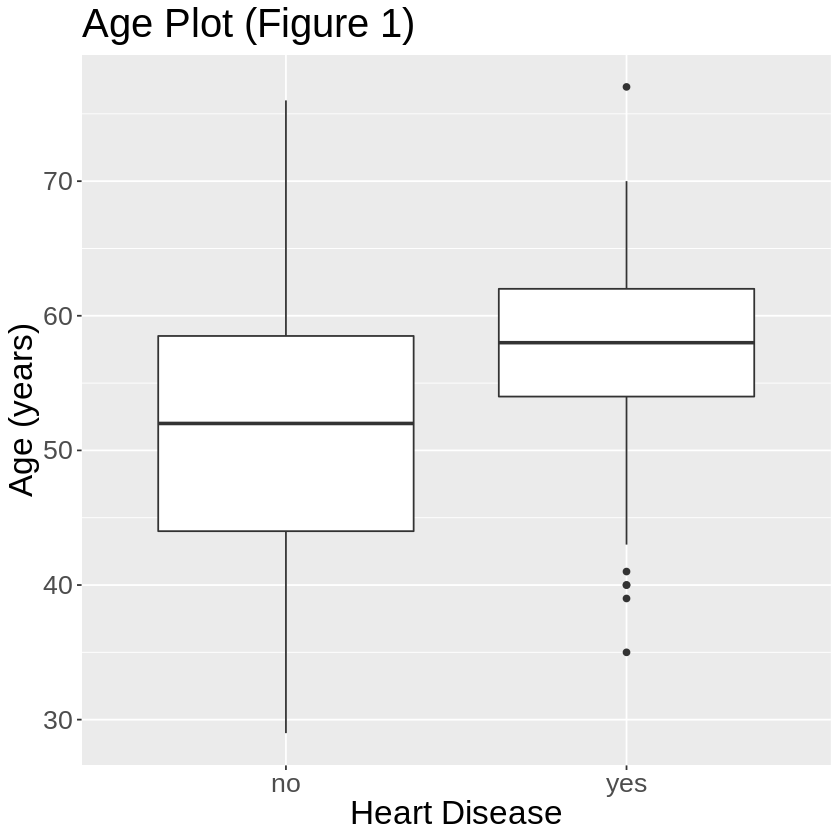

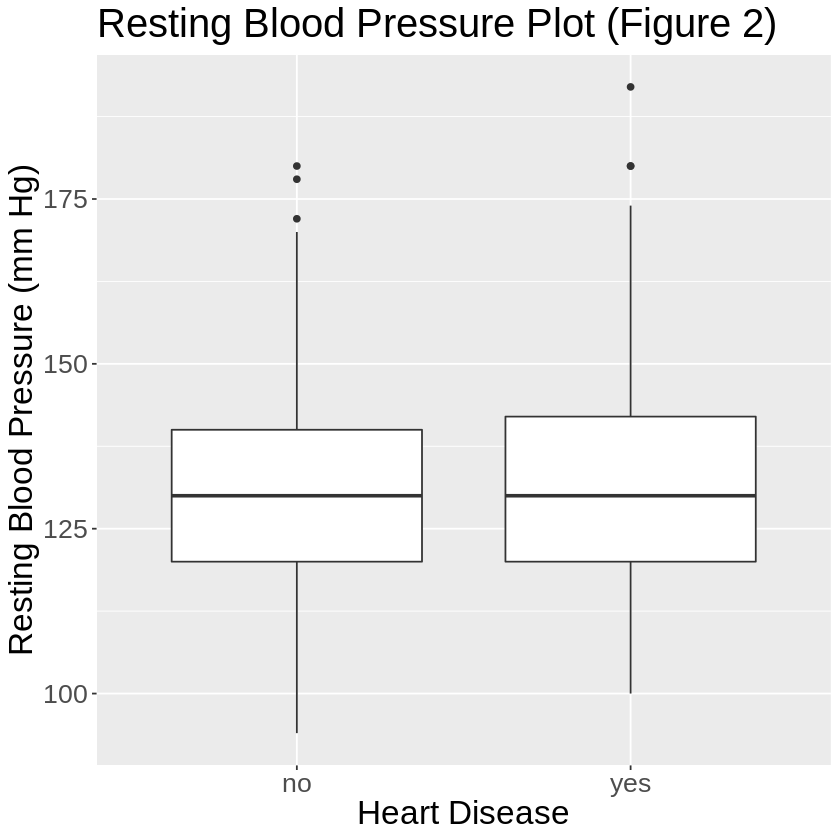

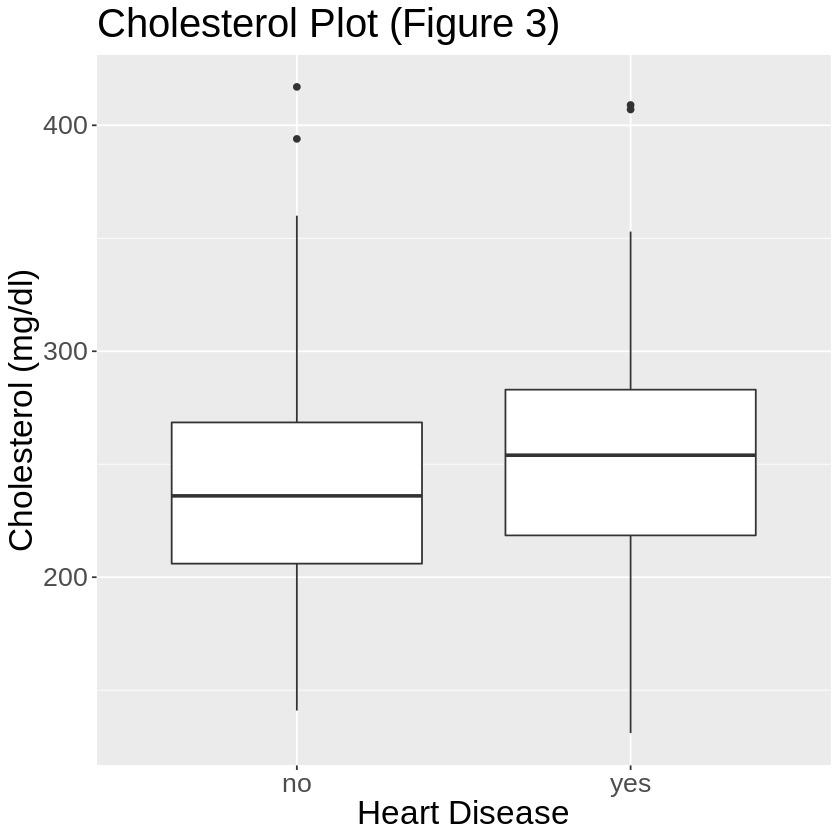

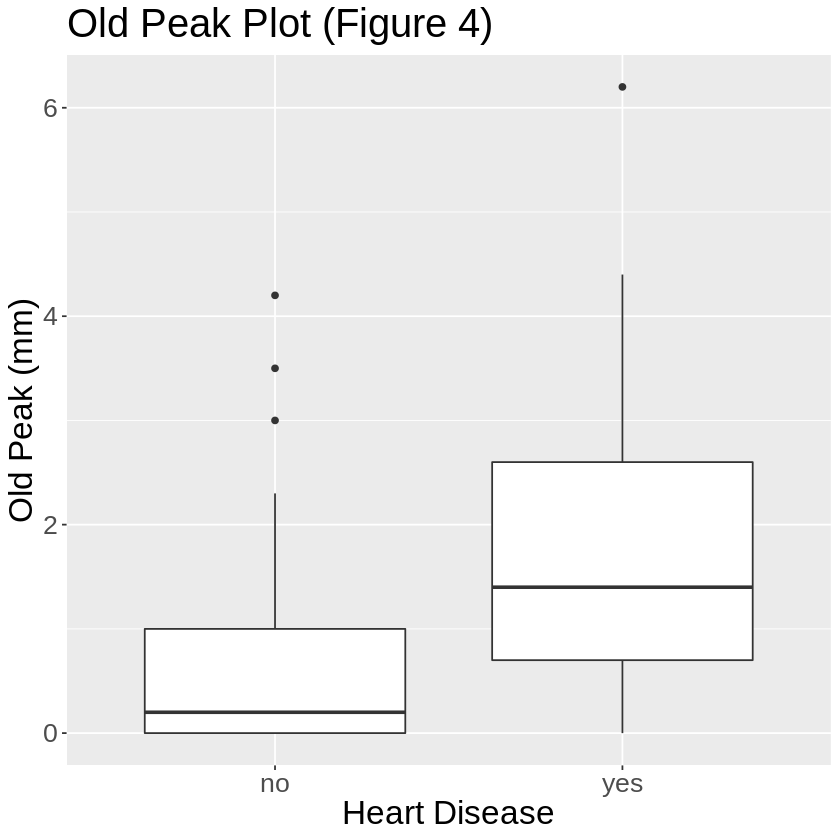

Warning message:
“Removed 3 rows containing non-finite values (stat_count).”


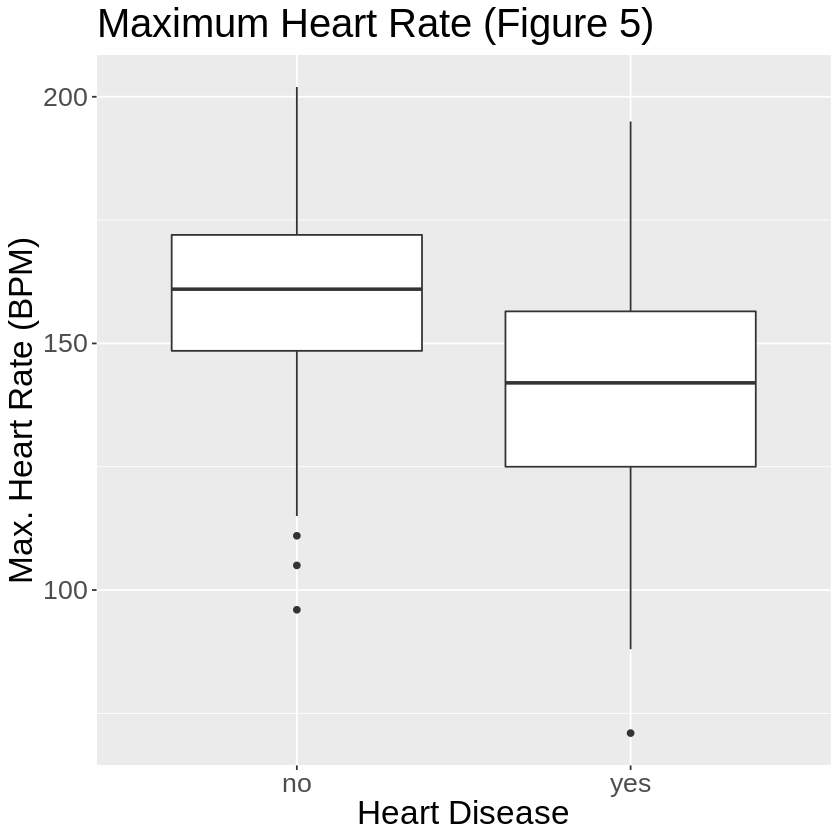

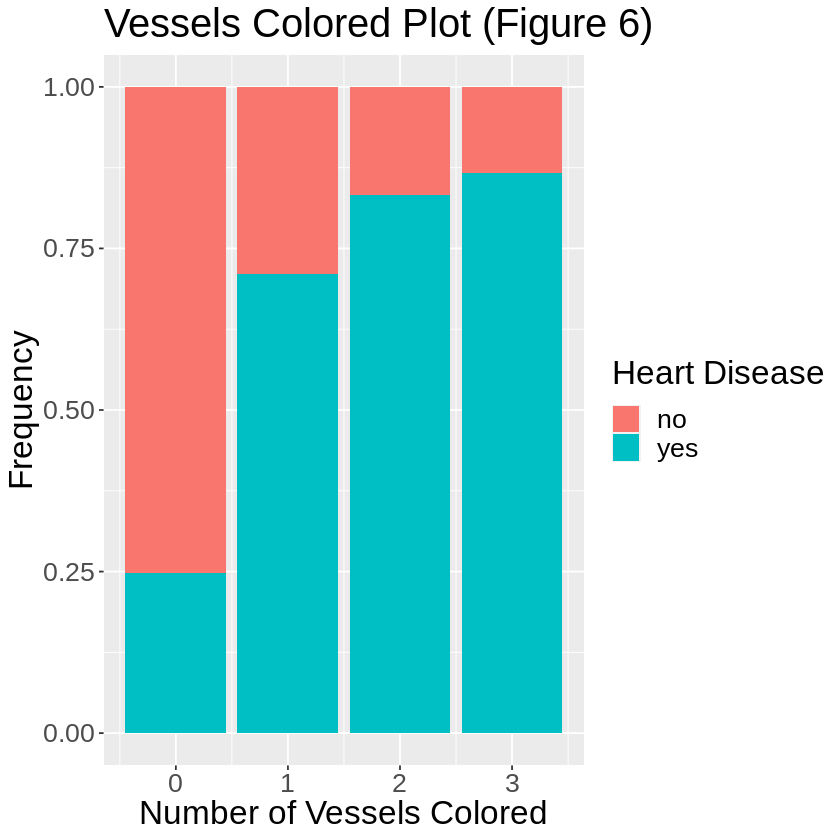

In [16]:
set.seed(2000) 

# generate box-plot visualizations
age_plot <- data_training |>
    ggplot(aes(y = age, x = presence_of_heart_disease)) + 
    geom_boxplot() + 
    ylab("Age (years)") +
    xlab("Heart Disease") +
    labs(title = "Age Plot (Figure 1)") +
    theme(text = element_text(size = 20))
age_plot

rbp_plot <- data_training |>
    ggplot(aes(y = resting_blood_pres, x = presence_of_heart_disease)) + 
    geom_boxplot() + 
    ylab("Resting Blood Pressure (mm Hg)") +
    xlab("Heart Disease") +
    labs(title = "Resting Blood Pressure Plot (Figure 2)") +
    theme(text = element_text(size = 20))
rbp_plot

cholesterol_plot <- data_training |>
    ggplot(aes(y = cholesterol, x = presence_of_heart_disease)) + 
    geom_boxplot() +
    ylab("Cholesterol (mg/dl)") +
    xlab("Heart Disease") +
    labs(title = "Cholesterol Plot (Figure 3)") +
    theme(text = element_text(size = 20))
cholesterol_plot

oldpeak_plot <- data_training |>
    ggplot(aes(y = oldpeak, x = presence_of_heart_disease)) + 
    geom_boxplot() +
    ylab("Old Peak (mm)") +
    xlab("Heart Disease") +
    labs(title = "Old Peak Plot (Figure 4)") +
    theme(text = element_text(size = 20))
oldpeak_plot 

mhr_plot <- data_training |>
    ggplot(aes(y = max_heart_rate, x = presence_of_heart_disease)) + 
    geom_boxplot() +
    ylab("Max. Heart Rate (BPM)") +
    xlab("Heart Disease") +
    labs(title = "Maximum Heart Rate (Figure 5)") +
    theme(text = element_text(size = 20))
mhr_plot

# generate bar graph visualization
data_vessels_plot2 <- data_training |>
    ggplot(aes(x = number_of_vessels_colored, fill = presence_of_heart_disease)) +
    geom_bar(position = "fill") +
    labs(x = "Number of Vessels Colored", y = "Frequency", fill = "Heart Disease", title = "Vessels Colored Plot (Figure 6)") +
    theme(text = element_text(size = 20))
data_vessels_plot2


Based on the above graphs and tables, it can be concluded that age, old peak, maximum heart rate, and number of vessels colored, all show an association with the presence of heart disease and therefore are good candidates to include in our model for predicting heart disease. In contrast, resting blood pressure and cholesterol show little to no association with the presence of heart disease and therefore will not be included as predictors in the classification model.

### Methods

Before we start building our k-nn classification model, we used visualizations (boxplots and bar graph) to see if there is an association between each predictor variable and the presence of heart disease   We concluded that age, number of vessels colored, old peak, and max. heart rate are the most valuable predictors to include in our model. 

Now, we will start to build our classification model based on the following steps: 

1. Create a knn classification model using k = tune(), and a recipe that uses the 4 parameters mentioned above as predictors on the training set and that scales and centers all the predictors.
2. Apply cross-validation on the training data to find the average accuracy from our training set’s prediction using vfold_cv() that folds the data ~5 times. 
3. Generate a workflow that uses tune_grid to get control over the number of Ks we need, and apply collect_metrics() for plotting.
4. Plot K using both geom_point() and geom_line(), and find the K that has the highest accuracy by looking for the peak.
5. Rebuild knn model with new k value.
6. Pass the new model and recipe into a new workflow using the training set and call fit().
7. Predict our classification result by passing the fitted training object and testing set into the predict() as arguments; bind cols if needed. 
8. Analyze accuracy using metrics and confusion matrices, and maybe use a bar graph or a line graph to visualize the actual accuracy and the error tolerant rate.

### Expected Outcomes

We expect to find that our model is able to predict the presence of heart disease relatively accurately given four variables: age, old peak, number of colored blood vessels, and maximum heart rate. The impact of this expected finding could be that the process for finding the heart's health improves, with fewer invasive examinations needed to predict health. Additionally, there may be future questions that this project inspires. One of these could be if this classifier is accurate enough to be used in a professional setting, and if it is, how can it be implemented? Another probable question is would using different predictors and/or training data have an effect on how accurately the model is? Overall, should the model produce accurate enough results, it could help doctors determine a person's heart health.

### Citations

Robert Detrano.(1990). "cleve.mod". Heart Disease Data Set, UCI machine learning repository. https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/cleve.mod

"Heart Disease in Canada".(2022). Government of Canada. https://www.canada.ca/en/public-health/services/publications/diseases-conditions/heart-disease-canada.html